In [1]:
# Import Python Tools:
from IPython.display import display, Latex
import pandas as pd
import numpy as np
from numpy import sqrt, pi, average, cos, sin, tan, arcsin, arccos, arctan, deg2rad, rad2deg
import matplotlib.pyplot as plt
import seaborn as sns

import load_combos

from steel_design.AISC import aisc
steel_density = 0.2833 #pci

from concrete_design import material_properties as conc
from concrete_design.steel_reinforcement import rebar_df as rebar
conc_density = 150.0 #pcf

from masonry_design import material_properties as cmu
from masonry_design.material_properties import NW_CMU

from wood_design.ref_design_values.table_4a.table_4a import table_4a_load
table_4a = table_4a_load(species="DF")

display(Latex(r"\newpage")) #pagebreak

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


<IPython.core.display.Latex object>

In [2]:
# Materials and Geometry
fc = 4000 #psi
fy = 60000 #psi
b = 12 #in
h = 18 #in
long_reinf = "#6"
dbar = rebar.loc[long_reinf, "Diameter"] #in
nbar = 6 #no. of bars
nbar_side = 3 #no. of bars each side
cc = 1 #in (concrete cover)
tie_reinf = "#3"
dtie = rebar.loc[tie_reinf, "Diameter"] #in (tie diameter)

In [3]:
d = h - cc - dtie - dbar/2 #in
dpr = cc + dtie + dbar/2 #in

d, dpr

(16.25, 1.75)

In [4]:
# Beta1 (stress block multiplier)

if fc <= 4000 and fc >= 2500:
    beta1 = 0.85
elif fc < 8000 and fc > 4000:
    beta1 = 0.85 - 0.05 * (fc - 4000) / 1000
elif fc >= 8000:
    beta1 = 0.65
else:
    print("error!")

beta1

0.85

In [5]:
# Steel Areas

Ast = rebar.loc[long_reinf, "Area"] * nbar_side #in^2
Asc = Ast

Ast, Asc

(1.32, 1.32)

In [6]:
# Stresses and Strains

Es = 29000000 #psi
ec = 0.003 # concrete max strain
ey = fy / Es

def stress_strain(c):
    es = ec * (d - c) / c           # steel strain at tension side
    fs = es * Es                    # steel stress at tension side
    es_pr = ec * (c - dpr) / c      # steel strain at compression side
    fs_pr = es_pr * Es              # steel stress at compression side
    a = beta1 * c                   # compression stress block depth
    return a, es, fs, es_pr, fs_pr

In [7]:
# Strength reduction factor (ties, not spirals)

def strength_factor():
    if es <= ey:
        phi, classify = 0.65, "compression-controlled"
    elif es >= ey + 0.003:
        phi, classify = 0.90, "tension-controlled"
    elif es > ey and es < ey + 0.003:
        phi, classify = 0.65 + 0.25 * (es - ey) / (0.003), "transition"
    return phi, classify

In [8]:
# Forces and Moments

def forces_moments():
    T = Ast * min(fy, fs)                   # tension force steel at tension side (lbs)
    Cc = 0.85 * fc * a * b                  # compression force in concrete (lbs)
    Cs = Asc * (min(fy, fs_pr) - 0.85*fc)   # compression force steel at compression side (lbs)

    Pn = Cc + Cs - T                        # Nominal axial load capacity (lbs)
    phiPn = phi * Pn                        # Ultimate axial load capacity (kips)

    # Solve for eccentricity by taking moment about T:
    # Sum of moments at T: Pn(ecc + h/2 - dpr) - Cc(d - a/2) - Cs(d - dpr) = 0
    ecc = (Cc*(d - a/2) + Cs*(d - dpr)) / Pn - (h/2 - dpr) #in (eccentricity)
    Mn = Pn * ecc                           # Nominal moment capacity (in-lbs)
    phiMn = phi * Mn                        # Ultimate moment capacity (in-lbs)

    return ecc, Pn, phiPn, Mn, phiMn

In [9]:
# Solve axial load and moment at varying 'c' values

nom_load = []
ult_load = []
nom_moment = []
ult_moment = []
eccentricity = []
phi_factor = []
c_value = []

c_values = np.arange(1.5*h, 0, -0.1)
for c in c_values:
    a, es, fs, es_pr, fs_pr = stress_strain(c)
    phi, classify = strength_factor()
    ecc, Pn, phiPn, Mn, phiMn = forces_moments()
    if ecc <= 1.5*h:
        nom_load.append(round(Pn))
        ult_load.append(round(phiPn))
        nom_moment.append(round(Mn))
        ult_moment.append(round(phiMn))
        eccentricity.append(round(ecc, 1))
        phi_factor.append(round(phi, 2))
        c_value.append(round(c, 3))

# change units
nom_load = [i / 1000 for i in nom_load]             # kips
ult_load = [i / 1000 for i in ult_load]             # kips
nom_moment = [i / 1000 / 12 for i in nom_moment]    # kip-ft
ult_moment = [i / 1000 / 12 for i in ult_moment]    # kip-ft
        
# Save the above calculated data in a dataframe
dict = {
    "c value": c_value,
    "ecc (in)": eccentricity,
    "Pn (kips)": nom_load,
    "phiPn (kips)": ult_load,
    "Mn (kip-ft)": nom_moment,
    "phiMn (kip-ft)": ult_moment,
    "phi": phi_factor,
}

df = pd.DataFrame(dict)

# Print the last 10 rows of the dataframe to verify
df.head(10)
#df[(df["phiMn (kip-ft)"] > 80) & (df["phiMn (kip-ft)"] < 120)].tail(20)

,c value,ecc (in),Pn (kips),phiPn (kips),Mn (kip-ft),phiMn (kip-ft),phi
0,27.0,-2.0,1056.795,686.917,-175.610250,-114.146667,0.65
1,26.9,-2.0,1053.070,684.496,-171.435750,-111.433250,0.65
2,26.8,-1.9,1049.344,682.073,-167.284667,-108.735000,0.65
3,26.7,-1.9,1045.615,679.650,-163.157000,-106.052000,0.65
4,26.6,-1.8,1041.884,677.225,-159.052667,-103.384250,0.65
5,26.5,-1.8,1038.151,674.798,-154.971667,-100.731583,0.65
6,26.4,-1.8,1034.416,672.371,-150.914083,-98.094167,0.65
7,26.3,-1.7,1030.680,669.942,-146.879833,-95.471917,0.65
8,26.2,-1.7,1026.941,667.512,-142.868917,-92.864750,0.65
9,26.1,-1.6,1023.200,665.080,-138.881250,-90.272833,0.65


In [10]:
# Calculate the maximum allowable axial load (concentric)

phi = 0.65
alpha = 0.80
Ag = b*h
As = rebar.loc[long_reinf, "Area"] * nbar
Pmax = phi * alpha * (0.85*fc*(Ag-As) + As*fy) / 1000
f"Max allowable concentric axial load = {round(Pmax, 2)} kips"

'Max allowable concentric axial load = 459.59 kips'

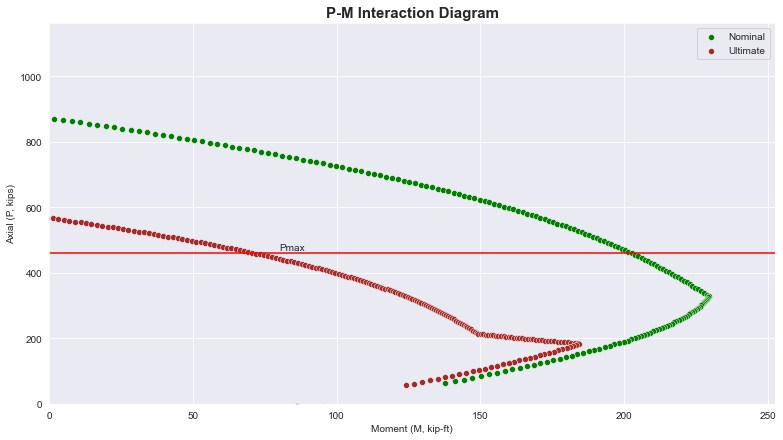

In [11]:
# Plotting the P-M Interaction Diagram

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(13,7))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=15)
ax = sns.scatterplot(x="Mn (kip-ft)", y="Pn (kips)", data=df, color="g", label="Nominal")
sns.scatterplot(x="phiMn (kip-ft)", y="phiPn (kips)", data=df, color="brown", label="Ultimate")
ax.set_xlabel("Moment (M, kip-ft)")
ax.set_ylabel("Axial (P, kips)")
plt.title("P-M Interaction Diagram")

plt.ylim(0, 1.1*max(dict["Pn (kips)"]))
plt.xlim(0, 1.1*max(dict["Mn (kip-ft)"]))
plt.axhline(Pmax, color="red")
plt.text(80, Pmax+10, "Pmax")

plt.show()